In [1]:
import tensorflow as tf
import collections
import tensorflow_federated as tff

import numpy as np
from jedi.debug import speed
from numpy.matrixlib.defmatrix import matrix
from sklearn.metrics import label_ranking_average_precision_score
from tensorflow_federated.python.aggregators.factory import ValueType
from tensorflow_federated.python.core.templates import aggregation_process


2026-01-20 09:19:51.234724: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-20 09:19:51.680706: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-20 09:19:51.680727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-20 09:19:51.680743: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-20 09:19:51.685065: I tensorflow/core/platform/cpu_feature_g

In [2]:
import tensorflow.keras.backend as K
import gc

K.clear_session()  # Clear TF session to free GPU memory
gc.collect()

64

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.14.1


2026-01-20 09:20:07.747990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-20 09:20:08.224122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-20 09:20:08.225886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
)

kidney_dataset = datagen.flow_from_directory(
    '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer',
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=32,
)

Found 3498 images belonging to 2 classes.


Batch shape: (32, 224, 224, 3)
Single image shape: (224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Label [1. 0.]


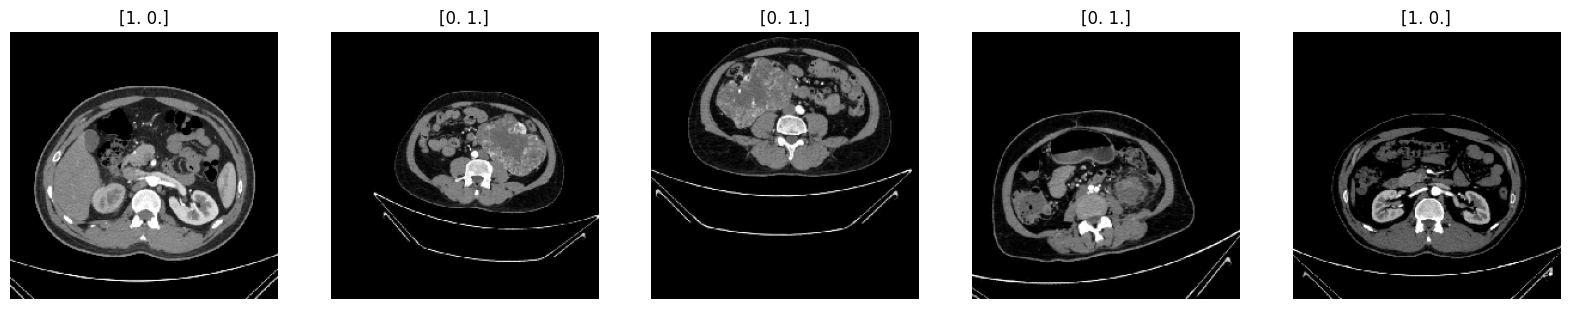

In [5]:
import matplotlib.pyplot as plt
images, labels = next(kidney_dataset)
for i in range(1):
    print("Batch shape:", images.shape)
    print("Single image shape:", images[0].shape)
    print("Min pixel value:", images.min())
    print("Max pixel value:", images.max())
    print("Label", labels[0])

fig, ax = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    ax[i].imshow(images[i])
    ax[i].set_title(labels[i])
    ax[i].axis('off')

plt.show()


In [6]:
type(kidney_dataset)

keras.src.preprocessing.image.DirectoryIterator

In [7]:
import os

data_dir = '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer'
class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

print(class_labels)

image_paths = []
labels = []
for class_name in class_names:
    path1 = os.path.join(data_dir, class_name)
    print(path1)
    paths = os.listdir(path1)
    for path in paths:
        image_paths.append(os.path.join(path1, path))
        labels.append(class_labels[class_name])

print(image_paths[1])

{'kidney_normal': 0, 'kidney_tumor': 1}
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_tumor
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal/kidney_normal_0403.jpg


In [8]:
NUM_MALICIOUS = 3
FLIP_PROB = 0.4

In [9]:
import os
import random

class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

def load_image(path, img_size=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

def create_client_dataset(image_paths, label, img_size=(224, 224), flip=False, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    images = []
    labels = []
    target_size=(64, 64)
    for i, path in enumerate(image_paths):
        img = load_image(path, img_size)
        img = tf.image.resize(img, target_size)
        images.append(img)
        labels.append(label[i])

    labels = np.array(labels, dtype=np.int32)
    if flip:
        rng = np.random.RandomState(seed)
        num_classes = len(np.unique(labels))
        n = len(labels)

        # randomly choose which samples to flip
        mask = rng.rand(n) < float(flip_prob)

        if mask.sum() > 0:
            rand_targets = rng.randint(0, num_classes, size=n)
            # ensure flipped label != original label
            rand_targets[rand_targets == labels] = (rand_targets[rand_targets == labels] + 1) % num_classes
            labels[mask] = rand_targets[mask]

    print(f"{len(images)}  {len(labels)}   malicious_client={flip}")
    ds = tf.data.Dataset.from_tensor_slices((images, labels.tolist()))
    ds = ds.shuffle(buffer_size=len(images)).batch(8)
    return ds


def prepare_client_dataset(data_dir, num_client, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    image_paths = []
    labels = []

    class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
    class_labels = {name: idx for idx, name in enumerate(class_names)}
    print(class_labels)

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        paths = os.listdir(class_path)
        for path in paths:
            image_paths.append(os.path.join(class_path, path))
            labels.append(class_labels[class_name])

    #image_paths = image_paths[:4000]
    combined = list(zip(image_paths, labels))
    rng = random.Random(seed)
    rng.shuffle(combined)

    combined = combined[:4000]
    image_paths, labels = zip(*combined)

    malicious_clients = []

    all_client_ids = [f"client_{i}" for i in range(num_client)]
    if num_malicious > 0:
        num_malicious = min(num_malicious, num_client)
        malicious_clients = rng.sample(all_client_ids, k=num_malicious)
    print("Malicious clients selected:", malicious_clients)

    clients_datasets = {}
    total_images = len(image_paths)
    for i in range(num_client):
        client_id = "client_{}".format(i)
        start = i * total_images // num_client
        end = ((i + 1) * total_images) // num_client
        print(client_id, start, end)
        do_flip = client_id in malicious_clients
        clients_datasets[client_id] = create_client_dataset(image_paths[start:end], labels[start:end], flip=do_flip, img_size=(224, 224), num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

    return clients_datasets


client_datasets = prepare_client_dataset(data_dir=data_dir, num_client=10, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

{'kidney_normal': 0, 'kidney_tumor': 1}
Malicious clients selected: ['client_7', 'client_5', 'client_1']
client_0 0 349


2026-01-20 09:20:25.598930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-20 09:20:25.600588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-20 09:20:25.602021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

349  349   malicious_client=False
client_1 349 699
350  350   malicious_client=True
client_2 699 1049
350  350   malicious_client=False
client_3 1049 1399
350  350   malicious_client=False
client_4 1399 1749
350  350   malicious_client=False
client_5 1749 2098
349  349   malicious_client=True
client_6 2098 2448
350  350   malicious_client=False
client_7 2448 2798
350  350   malicious_client=True
client_8 2798 3148
350  350   malicious_client=False
client_9 3148 3498
350  350   malicious_client=False


In [10]:
client_datasets

{'client_0': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_1': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_2': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_3': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_4': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_5': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_6': <_B

In [11]:
class_labels

{'kidney_normal': 0, 'kidney_tumor': 1}

In [12]:
type(client_datasets['client_0'])

tensorflow.python.data.ops.batch_op._BatchDataset

Client: client_0


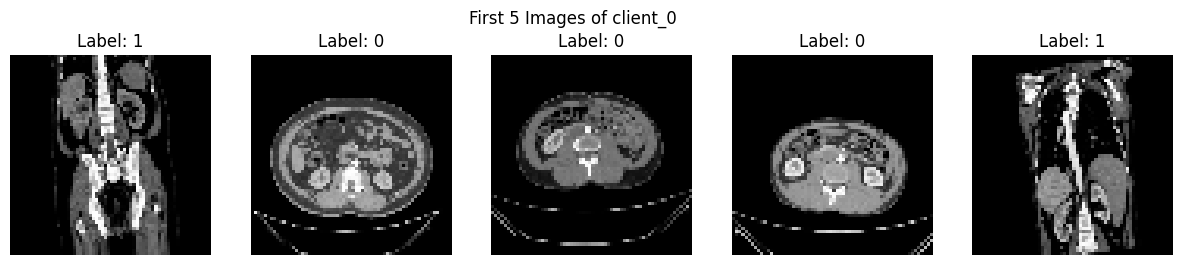

Client: client_1


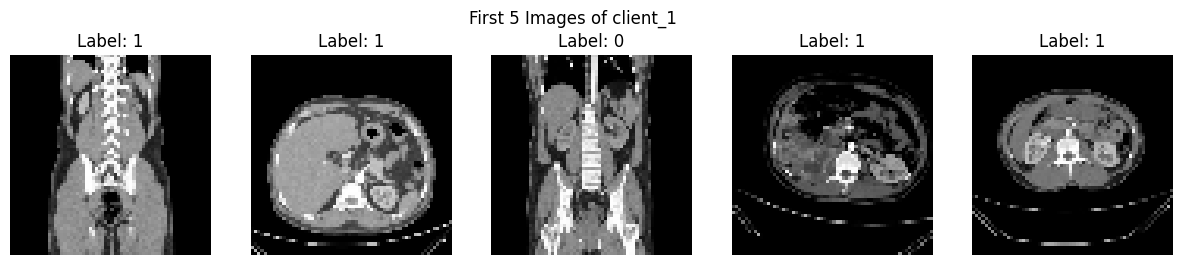

Client: client_2


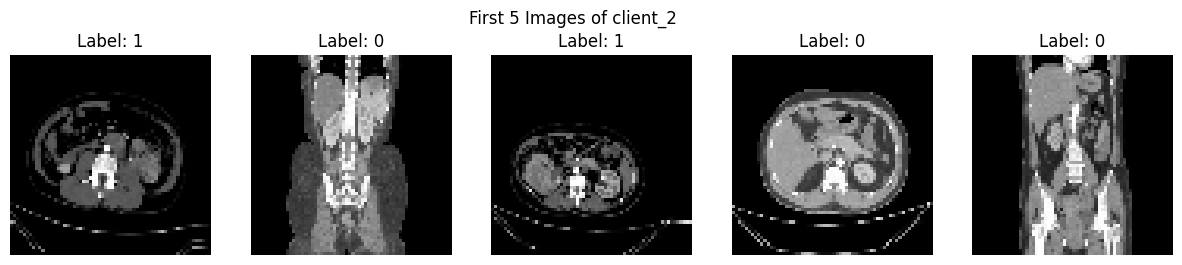

Client: client_3


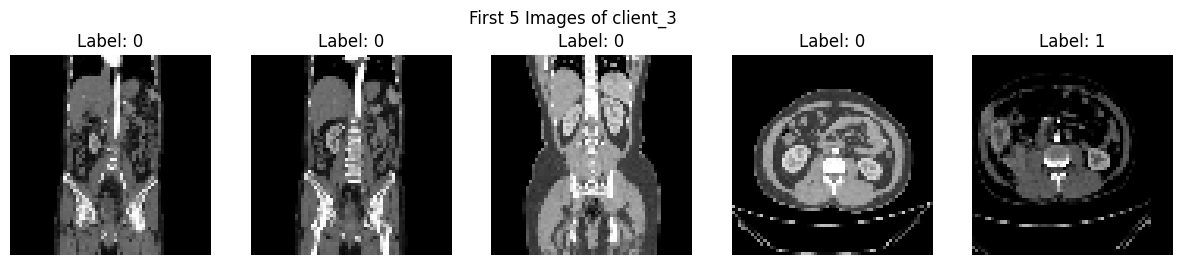

Client: client_4


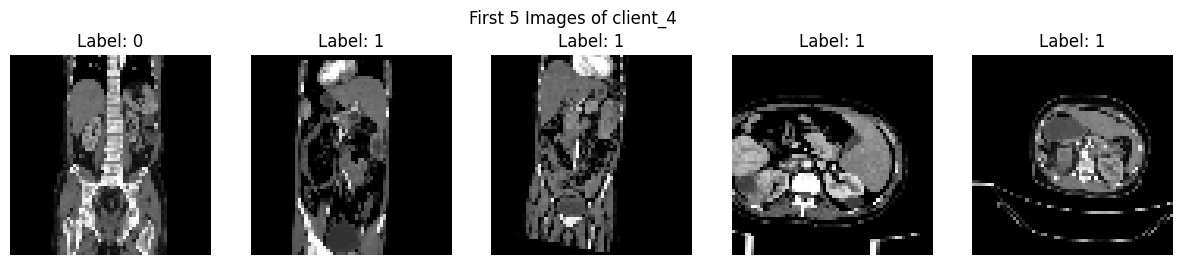

Client: client_5


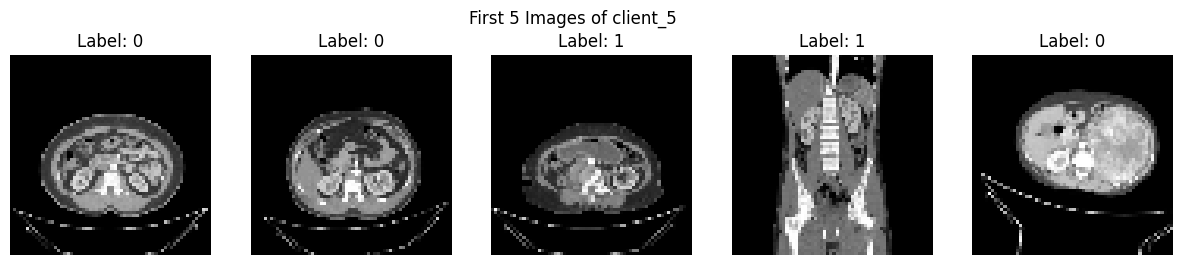

Client: client_6


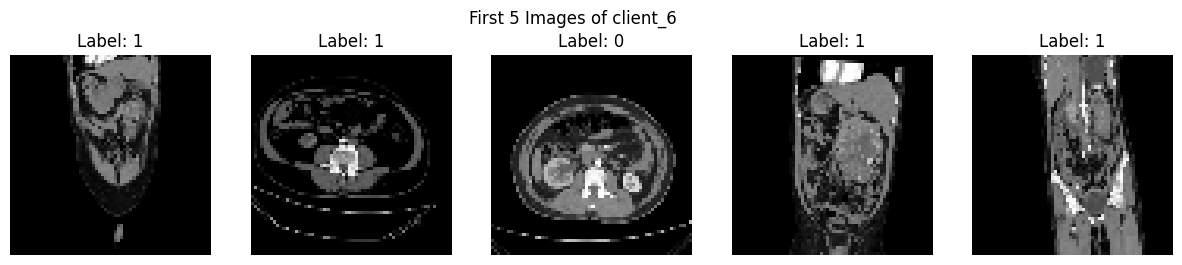

Client: client_7


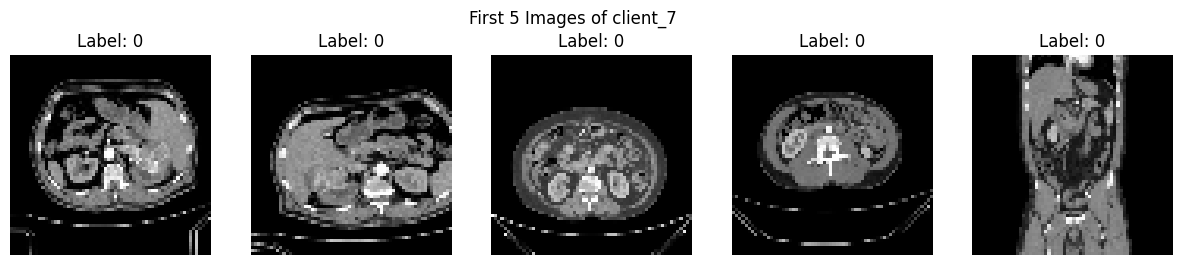

Client: client_8


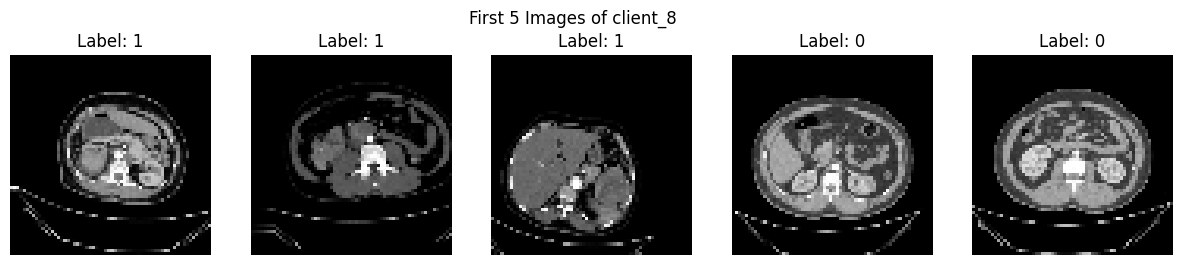

Client: client_9


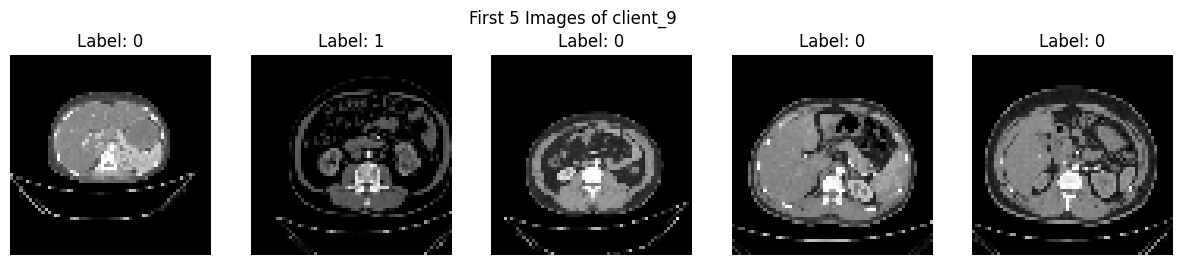

In [13]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, labels, title=None):
    plt.figure(figsize=(15, 3))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

def print_first_5_images_with_labels(clients_datasets):
    for client_id, dataset in clients_datasets.items():
        print(f"Client: {client_id}")

        images_collected = []
        labels_collected = []
        for batch_images, batch_labels in dataset.take(1):
            images_slice = batch_images[:5]
            labels_slice = batch_labels[:5]
            batch_np_images = images_slice.numpy()
            batch_np_labels = labels_slice.numpy()
            for img, lbl in zip(batch_np_images, batch_np_labels):
                images_collected.append(img)
                labels_collected.append(lbl)

        show_images_with_labels(images_collected, labels_collected, title=f"First 5 Images of {client_id}")


print_first_5_images_with_labels(client_datasets)


In [14]:
for images, labels in client_datasets['client_0'].take(1):
    print(images.shape)
    print(labels.shape)
    print(labels)

(8, 64, 64, 3)
(8,)
tf.Tensor([1 1 0 1 1 0 0 0], shape=(8,), dtype=int32)


In [15]:
## Creating the basic model
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # For 2-class classification
    ])
    return model


In [16]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

In [17]:
keras_model = create_keras_model()
tff_model = tff.learning.models.functional_model_from_keras(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss_fn =tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics_constructor = collections.OrderedDict(
            accuracy = tf.keras.metrics.SparseCategoricalAccuracy
        )
    )

2026-01-20 09:20:54.387397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-20 09:20:54.388492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-20 09:20:54.389357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
sample_model = create_keras_model()

sample_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # for one-hot or multi-class
    metrics=['accuracy']
)

In [19]:
sample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

In [20]:
with tf.device('/GPU:0'):
    sample_model.fit(client_datasets['client_0'], epochs=5, verbose=2)

Epoch 1/5


2026-01-20 09:21:02.856307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2026-01-20 09:21:03.932683: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7c27102c1920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-20 09:21:03.932729: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2026-01-20 09:21:03.942299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-20 09:21:04.017404: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 3s - loss: 0.6388 - accuracy: 0.6218 - 3s/epoch - 67ms/step
Epoch 2/5
44/44 - 0s - loss: 0.4034 - accuracy: 0.8481 - 104ms/epoch - 2ms/step
Epoch 3/5
44/44 - 0s - loss: 0.2698 - accuracy: 0.8854 - 132ms/epoch - 3ms/step
Epoch 4/5
44/44 - 0s - loss: 0.1838 - accuracy: 0.9370 - 178ms/epoch - 4ms/step
Epoch 5/5
44/44 - 0s - loss: 0.1099 - accuracy: 0.9542 - 175ms/epoch - 4ms/step


In [21]:
@tff.tensorflow.computation
def server_init():
    return tff.learning.models.ModelWeights(*tff_model.initial_weights)

In [22]:
@tff.federated_computation
def initialize_fn():
  return tff.federated_eval(server_init, tff.SERVER)

In [23]:
tf_dataset_type = tff.SequenceType(
    tff.types.tensorflow_to_type(tff_model.input_spec)
)

In [24]:
model_weights_type = server_init.type_signature.result

In [25]:
str(tf_dataset_type)

'<float32[?,64,64,3],int32[?]>*'

In [26]:
str(model_weights_type)

'<trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>'

In [27]:
tf.config.run_functions_eagerly(False)

In [28]:
in_client_update_method = []

In [34]:
@tf.function
#@tff.tensorflow.computation
def client_update(model, dataset, initial_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights and the optimizer
  # state.
  client_weights = initial_weights.trainable
  optimizer_state = client_optimizer.initialize(
      tf.nest.map_structure(tf.TensorSpec.from_tensor, client_weights)
  )

  # Use the client_optimizer to update the local model.
  for batch in dataset:
    x, y = batch
    with tf.GradientTape() as tape:
      tape.watch(client_weights)
      # Compute a forward pass on the batch of data
      outputs = model.predict_on_batch(
          model_weights=(client_weights, ()), x=x, training=True
      )
      loss = model.loss(output=outputs, label=y)

    # Compute the corresponding gradient
    grads = tape.gradient(loss, client_weights)

    # Apply the gradient using a client optimizer.
    optimizer_state, client_weights = client_optimizer.next(
        optimizer_state, weights=client_weights, gradients=grads
    )

    ##in_client_update_method.append(grads)

  weights = tff.learning.models.ModelWeights(client_weights, non_trainable=())
  in_client_update_method.append(weights)
  return weights

In [35]:
@tff.tensorflow.computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  client_optimizer = tff.learning.optimizers.build_sgdm(learning_rate=0.01)
  return client_update(tff_model, tf_dataset, server_weights, client_optimizer)

In [36]:
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  del model  # Unused, just take the mean_client_weights.
  return mean_client_weights

In [37]:
@tff.tensorflow.computation(model_weights_type)
def server_update_fn(mean_client_weights):
  return server_update(tff_model, mean_client_weights)

In [38]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [39]:
captured_client_weights = []

In [41]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):

    server_weights_at_client = tff.federated_broadcast(server_weights)

    client_weights  = tff.federated_map(
        client_update_fn, (federated_dataset, server_weights_at_client)
    )

    mean_client_weights = tff.federated_mean(client_weights)

    server_weights = tff.federated_map(server_update_fn, mean_client_weights)

    return server_weights, client_weights

In [42]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

In [43]:
str(federated_algorithm.initialize.type_signature)

'( -> <trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>@SERVER)'

In [44]:
client_datasets_list = [client_datasets[key] for key in sorted(client_datasets.keys())]
client_datasets_list = list(client_datasets.values())

In [45]:
server_weights = server_init()

for r in range(0, 4):
    server_weights, client_updates = next_fn(server_weights, client_datasets_list)
    captured_client_weights.append(client_updates)
    print("Finshed Round {}".format(r))

2026-01-20 09:37:20.893321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-20 09:37:20.895643: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2026-01-20 09:37:20.895722: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2026-01-20 09:37:20.896031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-20 09:37:20.897851: I tensorflow/compiler/xla/stream_executor/

Finshed Round 0
Finshed Round 1
Finshed Round 2
Finshed Round 3


In [46]:
len(captured_client_weights)

4

In [49]:
captured_client_weights[0][0]

ModelWeights(trainable=(array([[[[-0.08146856, -0.04773562, -0.12728444, -0.05493971,
          -0.11768558, -0.0275761 , -0.11296745,  0.1259617 ,
          -0.05859587,  0.03022536, -0.03484955,  0.02619223,
          -0.09463397,  0.0964769 , -0.1209126 , -0.05826652,
          -0.10025679,  0.06750546, -0.11737791,  0.02212817,
           0.04153911, -0.04713907,  0.08531201, -0.09002414,
           0.01609472,  0.02147708,  0.12192125, -0.04322257,
          -0.12195587, -0.09778744,  0.04163272, -0.12040518],
         [-0.03325078,  0.13004027,  0.08380446,  0.12302263,
          -0.10845092, -0.03994508,  0.09459189, -0.11843042,
           0.08818375,  0.06575429,  0.04742113, -0.05458789,
           0.00718745, -0.06644877, -0.05234506, -0.00175588,
          -0.09504892, -0.07252061, -0.10959636, -0.05745254,
          -0.04905283, -0.05662999, -0.04881618, -0.11194061,
          -0.10302389,  0.01485997, -0.04216449,  0.12984768,
          -0.11263395, -0.12844607,  0.131419

In [50]:
server_weights

ModelWeights(trainable=(array([[[[-7.88057819e-02, -4.76484895e-02, -1.26128659e-01,
          -5.63790686e-02, -1.17793262e-01, -2.64949147e-02,
          -1.13389090e-01,  1.25278920e-01, -5.60473502e-02,
           3.16723473e-02, -3.49528566e-02,  2.68466920e-02,
          -9.50446278e-02,  9.74324048e-02, -1.21865071e-01,
          -5.82179837e-02, -1.00286111e-01,  6.75210059e-02,
          -1.17310129e-01,  2.21056975e-02,  4.01179418e-02,
          -4.75195087e-02,  8.54687169e-02, -9.19776410e-02,
           1.73024461e-02,  2.10067872e-02,  1.21424876e-01,
          -3.83381657e-02, -1.21990070e-01, -9.78337079e-02,
           4.06093635e-02, -1.24798141e-01],
         [-3.05879768e-02,  1.30127385e-01,  8.49602297e-02,
           1.21583283e-01, -1.08558610e-01, -3.88638973e-02,
           9.41702574e-02, -1.19113244e-01,  9.07323137e-02,
           6.72012717e-02,  4.73178253e-02, -5.39334305e-02,
           6.77680969e-03, -6.54932633e-02, -5.32975309e-02,
          -1.707

In [58]:
len(in_client_update_method)

1

In [60]:
len(in_client_update_method[0][0])

10

In [65]:
in_client_update_method[0][0]

(<tf.Tensor 'ReduceDataset:0' shape=(3, 3, 3, 32) dtype=float32>,
 <tf.Tensor 'ReduceDataset:1' shape=(32,) dtype=float32>,
 <tf.Tensor 'ReduceDataset:2' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Tensor 'ReduceDataset:3' shape=(64,) dtype=float32>,
 <tf.Tensor 'ReduceDataset:4' shape=(3, 3, 64, 128) dtype=float32>,
 <tf.Tensor 'ReduceDataset:5' shape=(128,) dtype=float32>,
 <tf.Tensor 'ReduceDataset:6' shape=(4608, 128) dtype=float32>,
 <tf.Tensor 'ReduceDataset:7' shape=(128,) dtype=float32>,
 <tf.Tensor 'ReduceDataset:8' shape=(128, 2) dtype=float32>,
 <tf.Tensor 'ReduceDataset:9' shape=(2,) dtype=float32>)

In [82]:
server_weights

ModelWeights(trainable=(array([[[[-0.12390687,  0.14960939, -0.04412491, -0.09979042,
           0.09286003,  0.07402922, -0.13417074, -0.05246792,
          -0.10071993, -0.10747395, -0.07158917,  0.01586257,
           0.15709434, -0.08529576,  0.01825648,  0.02563244,
           0.10624826, -0.09538245, -0.11203948,  0.1400252 ,
          -0.01128464, -0.10284183,  0.06597265,  0.05444076,
          -0.01761871,  0.02086781,  0.04091875,  0.02927515,
          -0.09547754,  0.05062813,  0.11403148,  0.12156884],
         [ 0.11800732,  0.04417426, -0.05868704,  0.05180733,
          -0.10855941,  0.03530226,  0.03250273, -0.12804833,
          -0.02147461, -0.04622242,  0.06562038,  0.05925018,
           0.11488628, -0.01684737, -0.12185343,  0.09292196,
           0.15325573,  0.14473805, -0.03825369,  0.07172747,
           0.01819605, -0.10097811,  0.15110788,  0.05579998,
           0.13550368,  0.15268293,  0.12286053, -0.05149596,
           0.08057256, -0.05293353,  0.137952

In [21]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0),
    #model_aggregator= CollectClientUpdateds()
)

In [22]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[3,3,3,32],
      float32[32],
      float32[3,3,32,64],
      float32[64],
      float32[3,3,64,128],
      float32[128],
      float32[4608,128],
      float32[128],
      float32[128,2],
      float32[2]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<
    learning_rate=float32
  >,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    learning_rate=float32
  >
>@SERVER)


In [23]:
print(training_process.next.type_signature)

(<state=<global_model_weights=<trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>,distributor=<>,client_work=<learning_rate=float32>,aggregator=<value_sum_process=<>,weight_sum_process=<>>,finalizer=<learning_rate=float32>>@SERVER,client_data={<float32[?,64,64,3],int32[?]>*}@CLIENTS> -> <state=<global_model_weights=<trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>,distributor=<>,client_work=<learning_rate=float32>,aggregator=<value_sum_process=<>,weight_sum_process=<>>,finalizer=<learning_rate=float32>>@SERVER,metrics=<distributor=<>,client_work=<train=<sparse_categorical_accuracy=float32,loss=float32,num_examples=int64,num_batches=int64>>,aggregator=<mean_value=<>,mean_weight=<>>,finalizer=<update_non_finite=int32>>@SERVER>)


In [24]:
train_state = training_process.initialize()

2026-01-18 10:10:08.271201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-18 10:10:08.272613: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2026-01-18 10:10:08.272662: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2026-01-18 10:10:08.272903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-18 10:10:08.273904: I tensorflow/compiler/xla/stream_executor/

In [25]:
client_datasets_list = [client_datasets[key] for key in sorted(client_datasets.keys())]
client_datasets_list = list(client_datasets.values())

In [26]:
#import importlib
#serialization_utils = importlib.import_module('tensorflow_federated.python.program.serialization_utils')
#print(serialization_utils._MAX_SERIALIZED_DATASET_SIZE)
##serialization_utils._MAX_SERIALIZED_DATASET_SIZE = 1073741824

In [27]:
print(tff.__file__)

/home/mahesh/miniconda3/envs/tf_fed/lib/python3.9/site-packages/tensorflow_federated/__init__.py


In [56]:
print(training_process.next)

In [53]:
train_accuracies = []
train_losses = []
train_state_data = []
metrics_data = []
NUM_ROUNDS = 30

for round_num in range(1, NUM_ROUNDS):
  result = training_process.next(train_state, client_datasets_list)
  train_state = result.state
  train_state_data.append(train_state)
  metrics = result.metrics
  metrics_data.append(metrics)
  print('round {:2d}, metrics={}'.format(round_num, metrics))
  try:
        acc = metrics['client_work']['train']['sparse_categorical_accuracy']
        loss = metrics['client_work']['train']['loss']
  except KeyError:
        print(f"Available metric keys at round {round_num}: {metrics.keys()}")
        acc, loss = None, None

  train_accuracies.append(acc)
  train_losses.append(loss)
  print(f"Round {round_num}: accuracy={acc:.4f}, loss={loss:.4f}")

I0000 00:00:1768757488.231828    7010 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.866781), ('loss', 0.22460257), ('num_examples', 3498), ('num_batches', 440)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 1: accuracy=0.8668, loss=0.2246
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.876215), ('loss', 0.21363387), ('num_examples', 3498), ('num_batches', 440)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2: accuracy=0.8762, loss=0.2136
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.878502), ('loss', 0.2120084), ('num_examples', 3498), ('num_batches', 440)]))])), ('ag

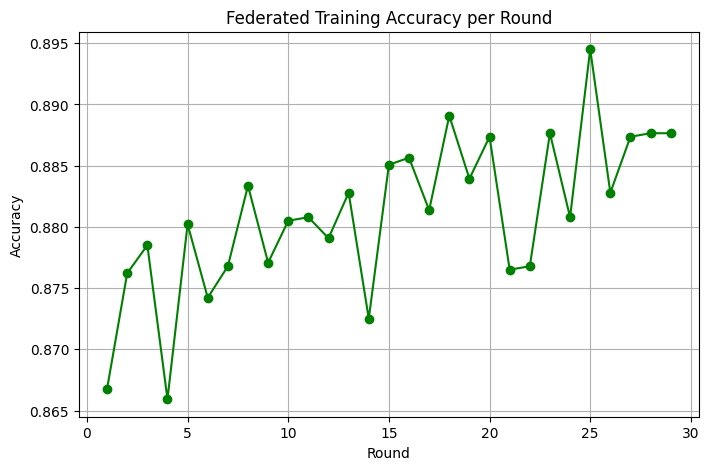

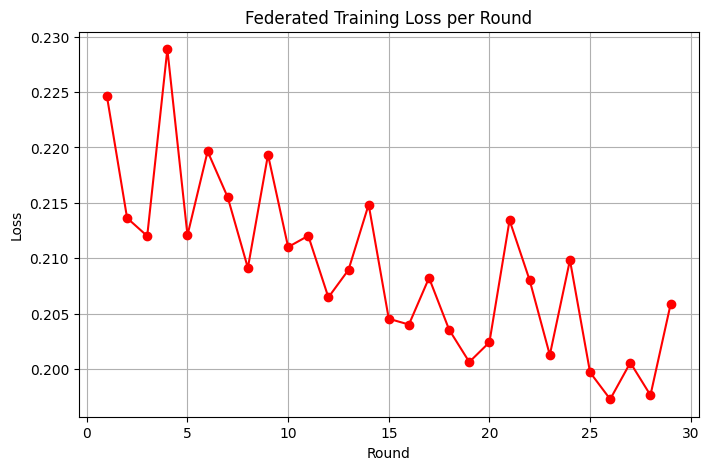

In [54]:
plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_ROUNDS), train_accuracies, color='green', marker='o')
plt.title('Federated Training Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_ROUNDS), train_losses, color='red', marker='o')
plt.title('Federated Training Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [39]:
print(result)

LearningProcessOutput(state=LearningAlgorithmState(global_model_weights=ModelWeights(trainable=[array([[[[ 1.33487165e-01, -5.69275133e-02,  1.80612653e-02,
           8.14823359e-02,  1.84232131e-01,  1.14056207e-01,
          -1.33329127e-02, -4.37792297e-03,  5.14774136e-02,
          -3.85449901e-02, -1.11237183e-01, -1.14565358e-01,
           8.67069513e-02, -1.98679492e-02,  5.75951077e-02,
           8.05224571e-03, -8.41140375e-02,  1.39792740e-01,
           2.96248998e-02,  1.17299259e-01,  8.82603973e-02,
          -1.34033516e-01,  1.07574351e-01,  6.32569939e-02,
          -2.10809018e-02,  2.13809207e-01,  2.14787084e-03,
           4.71387245e-02,  1.36442021e-01,  1.25630155e-01,
           9.83739644e-02,  1.54289737e-01],
         [-5.48077039e-02, -9.07980204e-02,  5.30528128e-02,
           9.33647305e-02,  1.41018704e-02,  3.67318541e-02,
           1.69027280e-02,  1.07746072e-01,  1.55160204e-01,
           5.81280291e-02,  2.18152162e-02, -3.43069769e-02,
     

In [40]:
len(train_state_data)

29

In [41]:
train_state_data[0]

LearningAlgorithmState(global_model_weights=ModelWeights(trainable=[array([[[[ 1.21271066e-01, -4.58806008e-02,  8.78192112e-03,
           8.14133883e-02,  1.69874892e-01,  1.16578832e-01,
          -2.18841638e-02, -1.05742663e-02,  4.26592045e-02,
          -4.36206311e-02, -1.11167982e-01, -1.09583564e-01,
           6.67311698e-02, -1.38189681e-02,  5.64791262e-02,
           4.52112406e-03, -8.79292116e-02,  1.25287563e-01,
           2.58096159e-02,  1.18402369e-01,  9.36101526e-02,
          -1.27381518e-01,  1.03017591e-01,  6.38681501e-02,
          -2.82742400e-02,  1.86029121e-01,  2.68477364e-03,
           4.66594435e-02,  1.19832978e-01,  1.21099912e-01,
           9.73471403e-02,  1.42826512e-01],
         [-6.70238510e-02, -7.97510669e-02,  4.37734574e-02,
           9.32957828e-02, -2.55431747e-04,  3.92545164e-02,
           8.35147500e-03,  1.01549692e-01,  1.46341994e-01,
           5.30523881e-02,  2.18844321e-02, -2.93251723e-02,
           7.34197199e-02, -9.523

In [42]:
train_state_data[0][0][0]

[array([[[[ 1.21271066e-01, -4.58806008e-02,  8.78192112e-03,
            8.14133883e-02,  1.69874892e-01,  1.16578832e-01,
           -2.18841638e-02, -1.05742663e-02,  4.26592045e-02,
           -4.36206311e-02, -1.11167982e-01, -1.09583564e-01,
            6.67311698e-02, -1.38189681e-02,  5.64791262e-02,
            4.52112406e-03, -8.79292116e-02,  1.25287563e-01,
            2.58096159e-02,  1.18402369e-01,  9.36101526e-02,
           -1.27381518e-01,  1.03017591e-01,  6.38681501e-02,
           -2.82742400e-02,  1.86029121e-01,  2.68477364e-03,
            4.66594435e-02,  1.19832978e-01,  1.21099912e-01,
            9.73471403e-02,  1.42826512e-01],
          [-6.70238510e-02, -7.97510669e-02,  4.37734574e-02,
            9.32957828e-02, -2.55431747e-04,  3.92545164e-02,
            8.35147500e-03,  1.01549692e-01,  1.46341994e-01,
            5.30523881e-02,  2.18844321e-02, -2.93251723e-02,
            7.34197199e-02, -9.52321440e-02,  3.30355996e-03,
            3.86342146e-

In [43]:
metrics

OrderedDict([('distributor', ()),
             ('client_work',
              OrderedDict([('train',
                            OrderedDict([('sparse_categorical_accuracy',
                                          0.87449974),
                                         ('loss', 0.22281525),
                                         ('num_examples', 3498),
                                         ('num_batches', 440)]))])),
             ('aggregator',
              OrderedDict([('mean_value', ()), ('mean_weight', ())])),
             ('finalizer', OrderedDict([('update_non_finite', 0)]))])

In [44]:
x = train_state_data[0][0][0]
(rows, cols) = (len(x), len(x[0]))
print(rows, cols)

10 3


In [45]:
def list_shape(lst):
    shape = []
    while isinstance(lst, list):
        shape.append(len(lst))
        lst = lst[0] if len(lst) > 0 else []
    return tuple(shape)

list_shape(train_state_data[0][0][0])

(10,)

In [51]:
metrics_data[0]['client_work']

OrderedDict([('train',
              OrderedDict([('sparse_categorical_accuracy', 0.838765),
                           ('loss', 0.29691768),
                           ('num_examples', 3498),
                           ('num_batches', 440)]))])